In [11]:
from cipells.experiments.continuous1d import *

In [12]:
import numpy as np
from matplotlib import pyplot, colors
%matplotlib notebook

In [163]:
positions = [-6.2, 7.4]
fluxes = [2.0, 3.0]

class ArrayPair:
    
    @classmethod
    def fromBounds(cls, x0, x1, **kwds):
        fine = np.linspace(x0 - 0.5, x1 + 0.5, 1 + 20*(x1 - x0))
        pixels = np.arange(x0, x1 + 1, dtype=int)
        return cls(fine=fine, pixels=pixels, **kwds)

    def __init__(self, fine, pixels):
        self.fine = fine
        self.pixels = pixels
        
    @property
    def bounds(self):
        return (self.pixels[0], self.pixels[-1])
        
class InputImage:
    
    def __init__(self, sigma, scaling, offset, sky):
        self.sky = sky
        self.to_sky = AffineTransform(scaling=scaling, offset=offset)
        self.from_sky = self.to_sky.inverse
        self.frame = ArrayPair.fromBounds(x0=int(np.floor(self.from_sky(float(sky.bounds[0])))),
                                          x1=int(np.ceil(self.from_sky(float(sky.bounds[-1])))))
        self.psf = GaussianPixelConvolution(Gaussian(scaling=sigma), Pixel())
        self.data = ArrayPair(pixels=np.zeros(self.frame.pixels.shape, dtype=float),
                              fine=np.zeros(self.frame.fine.shape, dtype=float))
        for p, f in zip(positions, fluxes):
            self.data.pixels[:] += self.psf(self.frame.pixels - self.from_sky(p))*f
            self.data.fine[:] += self.psf(self.frame.fine - self.from_sky(p))*f
            
    def project(self):
        s = self.psf(np.subtract.outer(self.frame.pixels, self.from_sky(self.sky.pixels)))
        return Accumulation(phi=np.dot(s.transpose(), s), psi=np.dot(self.data.pixels, s))

    def plot(self, title):
        pyplot.figure(title, figsize=(9.6, 6.4))
        pyplot.subplot2grid((4, 9), (0, 0), colspan=9)
        pyplot.plot(self.frame.pixels, self.data.pixels, ".", label='z')
        pyplot.plot(self.frame.fine, self.data.fine, alpha=0.5, label='z (fine)')
        pyplot.xlim(*self.frame.bounds)
        pyplot.ylabel("input data")
        pyplot.subplot2grid((4, 9), (1, 0), colspan=9)
        proj = self.project()
        pyplot.plot(self.sky.pixels, proj.psi, ".", label='psi')
        pyplot.xlim(self.to_sky(self.frame.bounds[0]), self.to_sky(self.frame.bounds[-1]))
        pyplot.ylabel("psi")
        
        norm = colors.SymLogNorm(1E-12, vmin=-1.0, vmax=1.0)
        pyplot.subplot2grid((4, 9), (2, 0), colspan=4, rowspan=2)
        pyplot.imshow(proj.phi, interpolation='nearest', origin='upper', norm=norm)
        pyplot.xlabel("phi")
        pyplot.subplot2grid((4, 9), (2, 4), colspan=4, rowspan=2)
        avg, delta = proj.mean_phi()
        pyplot.imshow(delta, interpolation='nearest', origin='upper', norm=norm)
        pyplot.xlabel("phi - mean(phi)")
        pyplot.colorbar(cax=pyplot.subplot2grid((4, 9), (2, 8), rowspan=2))
        
        pyplot.subplots_adjust(wspace=2.0, hspace=0.5)

class Accumulation:
    
    def __init__(self, phi, psi):
        self.phi = phi
        self.psi = psi

    def mean_phi(self, radius=40):
        n = self.phi.shape[0]
        avg = np.zeros(radius*2 + 1, dtype=float)
        for i in range(radius, n - radius):
            avg += self.phi[i, i - radius:i + radius + 1]
        avg /= (n - 2*radius)
        delta = self.phi.copy()
        for i in range(0, n):
            lo = -radius if i >= radius else -i
            hi = radius + 1 if i < n - radius else n - i
            delta[i, i + lo: i + hi] -= avg[radius + lo: radius + hi]
        return avg, delta

<IPython.core.display.Javascript object>


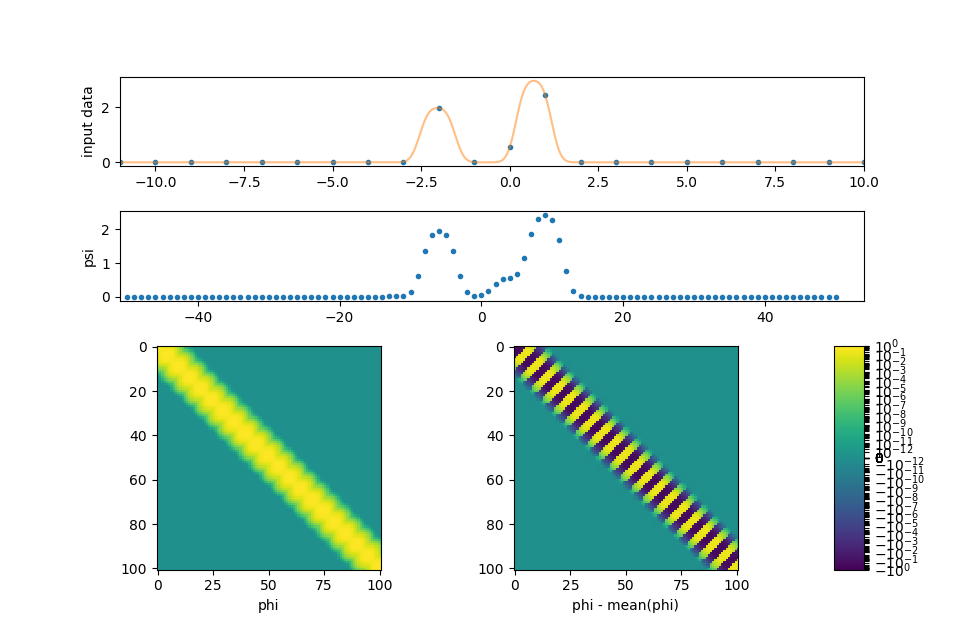

In [164]:
sky = ArrayPair.fromBounds(-50, 50)
input1 = InputImage(sigma=0.2, scaling=5.0, offset=4.0, sky=sky)
input1.plot("Severely Undersampled")

<IPython.core.display.Javascript object>


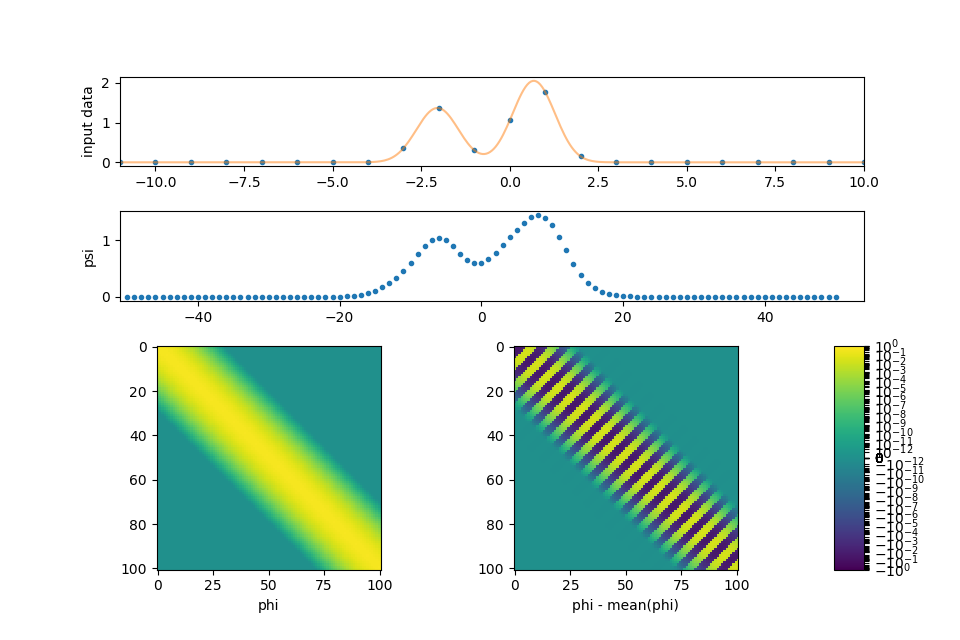

In [165]:
input2 = InputImage(sigma=0.5, scaling=5.0, offset=4.0, sky=sky)
input2.plot("Moderately Undersampled")

<IPython.core.display.Javascript object>


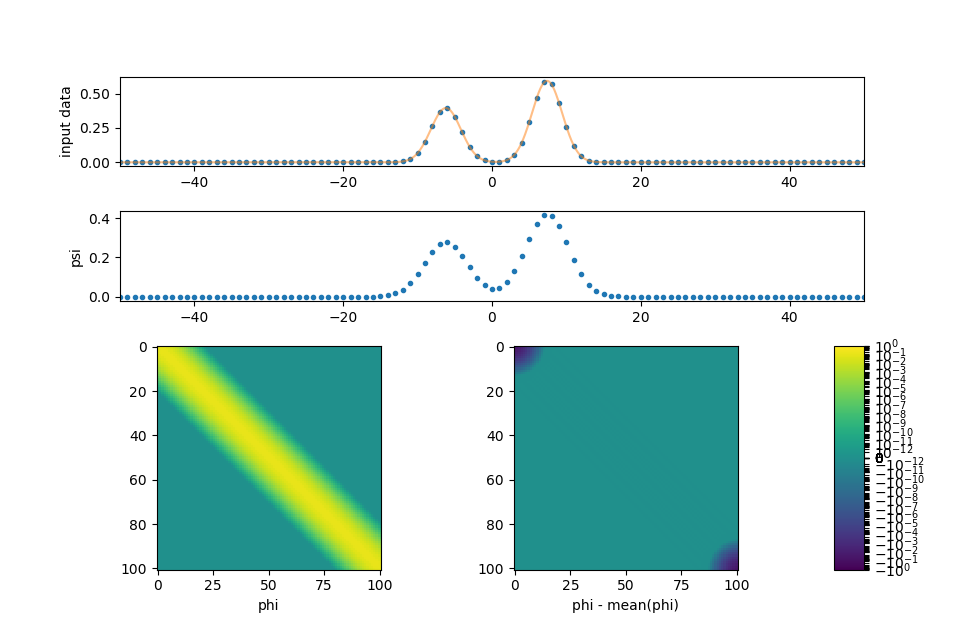

In [166]:
input3 = InputImage(sigma=2.0, scaling=1.0, offset=0.0, sky=sky)
input3.plot("Well-Sampled, No Scaling")

<IPython.core.display.Javascript object>


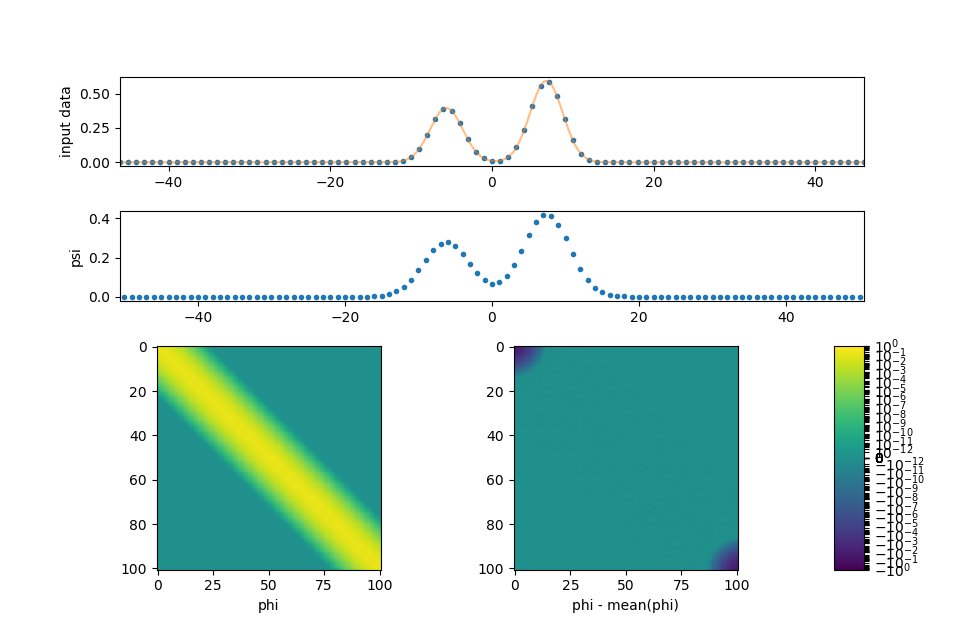

In [167]:
InputImage(sigma=2.0, scaling=1.1, offset=0.0, sky=sky).plot("Well-Sampled, 10% Scaling.")

<IPython.core.display.Javascript object>


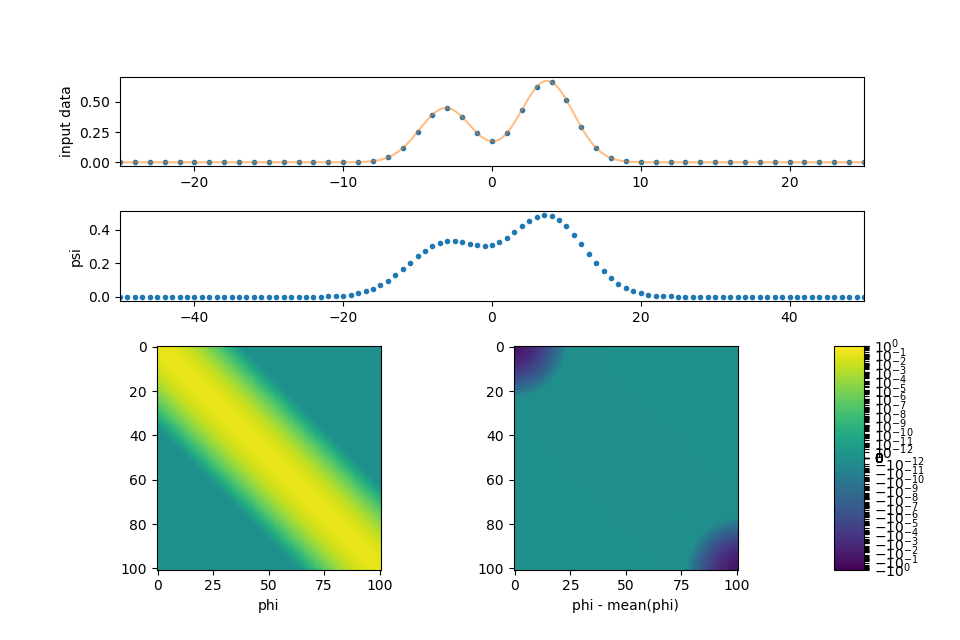

In [168]:
InputImage(sigma=1.75, scaling=2.0, offset=0.0, sky=sky).plot("Well-Sampled, 200% Scaling.")

In [65]:
np.add.accumulate?